##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In diesem Tutorial werden Blumenbilder klassifiziert.

Es folgt den grundlegenden Machine Learning Schritten:

1. Daten betrachten und verstehen
2. Eingabe Pipeline erstellen
3. Model bauen
4. Model trainieren
5. Model testen
6. Model verbessern und den Prozess wiederholen

## Import TensorFlow und benötigte Bibliotheken

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Dataset downloaden und kennenlernen

Dieses Tutorial nutzt ein Dataset mit ca. 3,700 Fotos von Blumen. Das Datenset besteht aus fünf Unterverzeichnissen pro Klasse:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


Jetzt steht eine Kopie des Datasets zur Verfügung. Insgesamt gibt es 3,670 Bilder:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Hier einige Rosen:

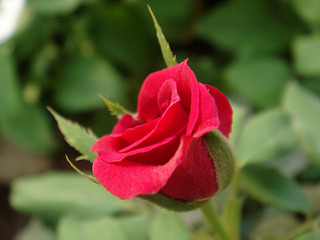

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

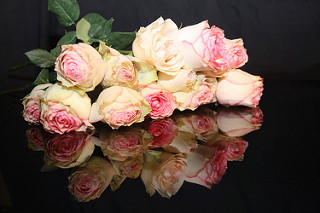

In [6]:
PIL.Image.open(str(roses[1]))

Und einige Tulpen:

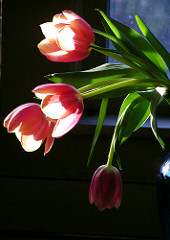

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

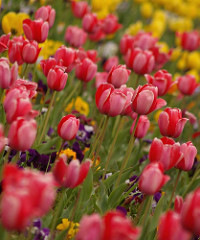

In [8]:
PIL.Image.open(str(tulips[2]))

# Laden der Daten mit Keras

Die Bilder müssen von der Festplatte geladen werden. Dabei hilft die `tf.keras.utils.image_dataset_from_directory` Methode.
Dies erzeugt aus einem Verzeichnis voller Bilder ein `tf.data.Dataset` mit wenigen Codezeilen.

## Datenset anlegen

Parameter:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

80% der Bilder sollten für Training genutzt werden und die restlichen 20% zur Validierung.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-08-16 14:43:14.023367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-16 14:43:14.023672: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Die Klassenbezeichner finden sich im `class_names` attribute des Ddatensets. Diese entsprechen den Unterverzeichnisnamen .

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Daten anzeigen

Hier die ersten neun Bilder der Datensets.

2023-08-16 14:43:37.225250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-08-16 14:43:37.225556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


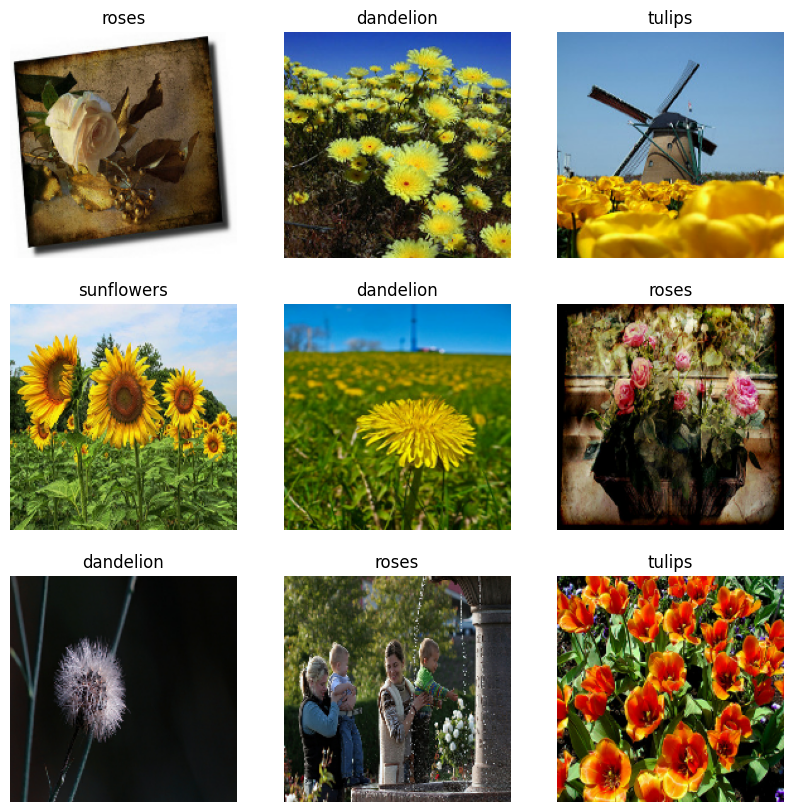

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Performance des Datensets anpassen

Die Puffergrössen müssen angepaßt werden um ein schnelles Laden zu gewährleisten.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardisierung der Daten

Die Rot/Grün/Blau Kanäle der Bilder sind im Bereich von `[0, 255]`.
Das ist nicht ideal für ein Neuronales Netzwerk. Für dieses sollte der Input klein sein.

Wir werden die Werte standardisieren auf einen Interval von `[0, 1]` mittels der Methode `tf.keras.layers.Rescaling`:

In [15]:
normalization_layer = layers.Rescaling(1./255)

Es gibt zwei Möglichkeiten diesen Layer anzuwenden. Wir können ihn direkt auf die Daten anwenden mit `Dataset.map`.

Oder wir können ihn in unser Model einbauen, was wir weiter unten tun werden.

# Create the model

The [Sequential](../../guide/keras/sequential_model.ipynb) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [16]:
num_classes = 5

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren des Models



In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Übersicht

Mit der `Model.summary` Methode können wir uns alle Layer des Models anschauen:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training des Models

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-08-16 14:48:07.253438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-08-16 14:48:07.253671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.4550

2023-08-16 14:48:25.941208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [734]
	 [[{{node Placeholder/_0}}]]
2023-08-16 14:48:25.941521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [734]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 20s 202ms/step - loss: 1.2838 - accuracy: 0.4550 - val_loss: 1.0446 - val_accuracy: 0.5613
Epoch 2/10
92/92 [==============================] - 18s 195ms/step - loss: 0.9709 - accuracy: 0.6233 - val_loss: 0.9895 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 19s 202ms/step - loss: 0.8084 - accuracy: 0.6955 - val_loss: 0.8679 - val_accuracy: 0.6744
Epoch 4/10
92/92 [==============================] - 18s 195ms/step - loss: 0.6085 - accuracy: 0.7762 - val_loss: 0.8640 - val_accuracy: 0.6771
Epoch 5/10
92/92 [==============================] - 18s 197ms/step - loss: 0.3794 - accuracy: 0.8655 - val_loss: 1.0783 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 18s 201ms/step - loss: 0.2228 - accuracy: 0.9292 - val_loss: 1.1240 - val_accuracy: 0.6649
Epoch 7/10
92/92 [==============================] - 18s 197ms/step - loss: 0.1247 - accuracy: 0.9629 - val_loss: 1.3533 - val_accuracy: 0.6771
Epoch 8/10

## Anzeigen der Trainingsresultate

Erstellen eines Diagramms auf dem Trainingsset und dem Validierungsset:

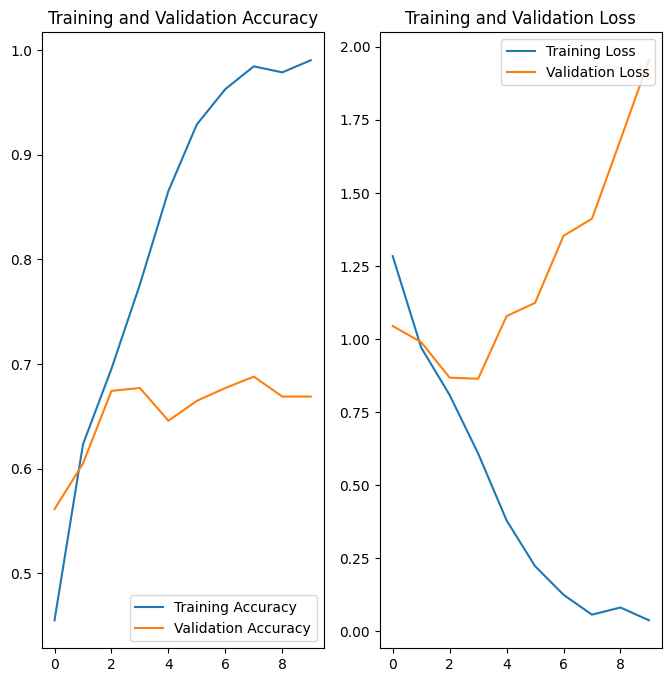

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Die Plots zeigen dass die Trainingsgenauigkeit und die Validierungsgenauigkeit sich um Größeneinheiten unterscheiden. Und die Genauigkeit des Modells liegt lediglich bei 60%.

Was ist also schief gelaufen und was können wir dagegen tun?

## Overfitting

Im obigen Diagramm wächst die Trainingsgenauigkeit Linear, aber die Validierungsgenauigkeit bricht bei ca. 60% ab.
Ebenso ist die Differenz zwischen Training und Validierung sehr groß. Dies ist ein Zeichen für [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Bei kleinen Mengen an Trainingsbeispielen lernen die Modelle manchmal unerwünschte Details oder Hintergrundrauschen der Trainingsbilder. Wenn dies zuviel passiert hat das einen negativen Einfluss auf die Performance.
Diese Overfitting bedeutet das das Model Schwierigkeiten hat sich auf ein neues Dataset zu Generalisieren.

Wir werden hier *data augmentation* nutzen und *Dropout* Layer zeigen.

## Data augmentation

Overfitting passiert generell when es zu wenige Trainingsbilder gibt.
Mit Data Augmentation werden aus alten Bildern neue Bilder generiert die geringfügig verändert werden um so in Summe aus wenigen Bildern mehr zu machen.

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Schauen wir uns einige der neuen Bilder an:

2023-08-16 14:53:50.648147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-08-16 14:53:50.648478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


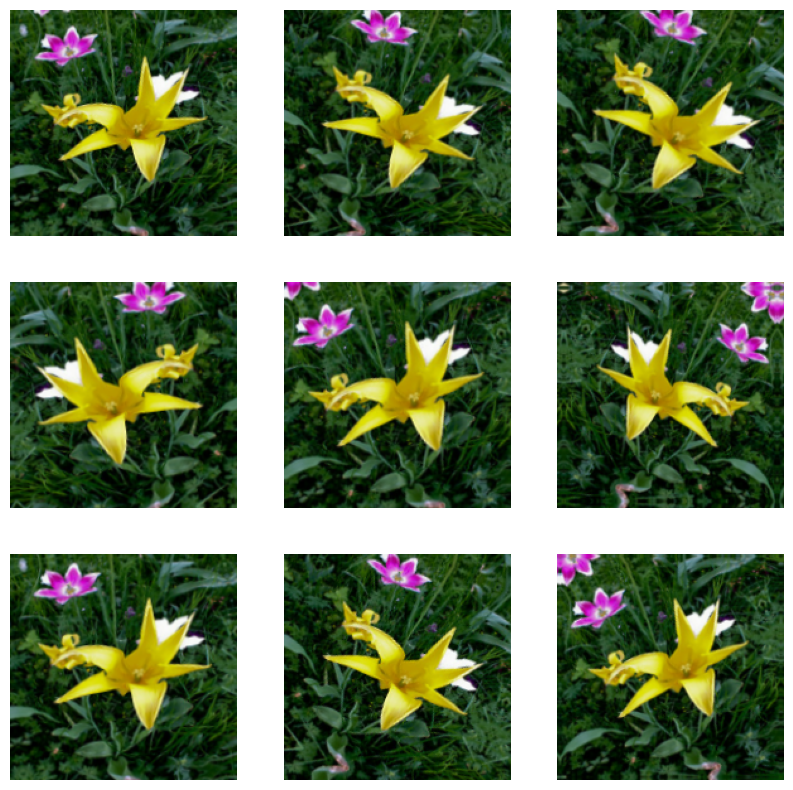

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Eine andere Technik um Overfitting zu vermeiden ist der [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) im Netzwerk.

Ein Dropoutlayer läßt zufällig einige Eingabe aus der Verarbeitung im Netzwerk fallen (die Aktivierung wird auf 0 gesetzt).
Bei dem Dropoutlayer kann man mit Kommazahlen die Prozentanzahl an ignorierten Eingaben einstellen (0.1=10% etc.).

Wir erzeugen jetzt ein neues Netzwerk mit  `tf.keras.layers.Dropout` Layern und werden das dann mit unseren data augmented Eingaben trainieren:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren und trainieren des Models

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 20s 211ms/step - loss: 1.2683 - accuracy: 0.4486 - val_loss: 1.2208 - val_accuracy: 0.4891
Epoch 2/15
92/92 [==============================] - 20s 216ms/step - loss: 1.0182 - accuracy: 0.6042 - val_loss: 0.9843 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 20s 221ms/step - loss: 0.9432 - accuracy: 0.6213 - val_loss: 1.0235 - val_accuracy: 0.6022
Epoch 4/15
92/92 [==============================] - 20s 214ms/step - loss: 0.8833 - accuracy: 0.6631 - val_loss: 0.8426 - val_accuracy: 0.6594
Epoch 5/15
92/92 [==============================] - 20s 218ms/step - loss: 0.8257 - accuracy: 0.6734 - val_loss: 0.8151 - val_accuracy: 0.6880
Epoch 6/15
92/92 [==============================] - 20s 219ms/step - loss: 0.7810 - accuracy: 0.6952 - val_loss: 0.8569 - val_accuracy: 0.6689
Epoch 7/15
92/92 [==============================] - 20s 215ms/step - loss: 0.7527 - accuracy: 0.7030 - val_loss: 0.8104 - val_accuracy: 0.6880

## Anzeigen der Trainingsergebnisse

Nachdem wir die Data Augmentation und den `tf.keras.layers.Dropout` Layer eingesetzt haben ist weniger overfitting als vorher zu erkennen. Ebenso ist die Genauigkeit des Trainings und des Validierungsdataset näher bei einander.

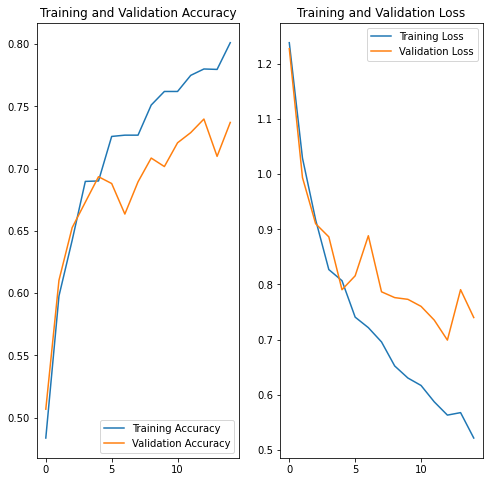

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Vorhersage auf neuen Daten

Schlußendlich werden wir unser Model auf neuen Daten anwenden die nicht im Trainings oder Validierungs Set enthalten waren.

In [57]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Dieses Bild gehört zu {} mit {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Dieses Bild gehört zu sunflowers mit 97.77 %.
